In [1]:
import numpy as np
from numpy import nan
from scipy import optimize
import os, sys, time, torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from CCM import CCM
from simpler_CCM import simpler_CCM
from DMTS import DMTS

In [2]:
from tqdm.notebook import tqdm

# Single population

In [3]:
computer = "cpu"
dev_str = 'cpu'
cores = 6
num_workers = 4 * cores
enc = torch.float64
dev = torch.device(computer)

info = True
reject = True 
plot = False 

mod_prm = torch.as_tensor([.020, .600, 4.5, 0., 1.9, 2.6, 1.5, 1.2, 7., 7., 7., 7., 1/45], device=dev, dtype=enc)
sim_prm = torch.as_tensor([5., .01, 1., 1e-12, 1e-3, nan], device=dev, dtype=enc)

## First explorations

In [4]:
Ae, Ap, As, Av = 169, 268, 709, 634
dof = torch.as_tensor([
    
    Ae, Ap, As, Av, # Ae, Ap, As, Av (4)
    # wee, 	  wpe,     wse,     wes,     wvs,     wep,     wpp,     wsp,     wev,     wsv (10) :
    .136*Ae, .101*Ap, .002*As, .077*Ae, .048*Av, .112*Ae, .093*Ap, .0*As, .041*Ae, .001*As, 
    3.9, 4.5, 3.6, 2.9, # Ie_ext, Ip_ext, Is_ext, Iv_ext (5)
    0.8, .0598*Ae, .02 # q, J_adp, sigma (3)
    
], device=dev, dtype=enc)

In [4]:
ccm = CCM(dof, mod_prm, sim_prm)
dmts = DMTS(ccm)

In [5]:
dmts.print_stats()

Number of trials :	 5 
Successful operations :	 5 	 5 	 0 
Ratios :		 1.0 	 1.0 	 0.0


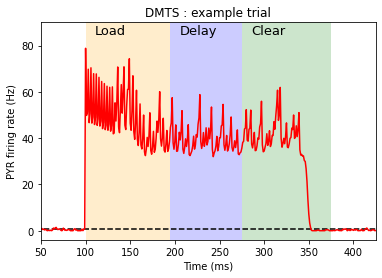

In [6]:
dmts.plot_trials(0)

In [7]:
ccm.S

[array([0.6032665 , 0.87046909, 0.50015718, 0.37357392]),
 array([0.61717318, 0.33423745, 3.29694262, 4.53982974]),
 array([10.91154219,  2.92078976,  8.64375169,  7.50461372])]

## INs' Iext impact on memory stats

In [8]:
task_prm = [30, 1, (1.850,1.950), (2.65, 2.75), (3.65,3.75)]

In [9]:
## SOM

dof_som = dof.clone()
stats_som = []
dof_som[16] -= 2.5

print(dof_som[16])

for i in tqdm(range(20)):
    ccm = CCM(dof_som, mod_prm, sim_prm)
    dmts = DMTS(ccm, task_prm)
    stats_som.append(dmts.maintenances/dmts.nb_trials)
    dof_som[16] += 0.25

tensor(1.1000, dtype=torch.float64)


In [10]:
## VIP

dof_vip = dof.clone()
stats_vip = []
dof_vip[17] -= 2.5

for i in tqdm(range(20)):
    ccm = CCM(dof_vip, mod_prm, sim_prm)
    dmts = DMTS(ccm, task_prm)
    stats_vip.append(dmts.maintenances/dmts.nb_trials)
    dof_vip[17] += 0.25

In [11]:
## PV

dof_pv = dof.clone()
stats_pv = []
dof_pv[15] -= 2.5

for i in tqdm(range(20)):
    ccm = CCM(dof_pv, mod_prm, sim_prm)
    dmts = DMTS(ccm, task_prm)
    stats_pv.append(dmts.maintenances/dmts.nb_trials)
    dof_pv[15] += 0.25

[Text(0, 0.5, 'P(maintenance)'), Text(0.5, 0, 'Delta Iext')]

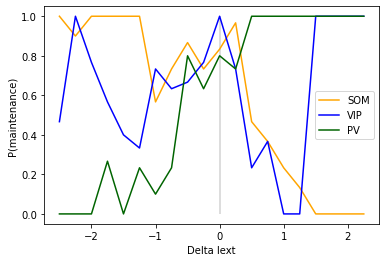

In [12]:
x = [- 2.5 + 0.25*i for i in range(20)]

fig, ax = plt.subplots()
ax.plot(x, stats_som, color = 'orange')
ax.plot(x, stats_vip, color = "blue")
ax.plot(x, stats_pv, color = 'darkgreen')
ax.vlines(x= 0, ymin = 0, ymax = 1, color = 'lightgrey')
ax.legend(['SOM', 'VIP', 'PV'], loc = 'right')
ax.set(xlabel = 'Delta Iext', ylabel = 'P(maintenance)')

In [11]:
'''
x = np.linspace(1, 100, 100)
y = 50*np.cos(x)

plt.rcParams['axes.facecolor'] = 'white'

fig, ax = plt.subplots()
ax.plot(x)
ax.plot(y)

#ax.vlines(x = [5,10], ymin  = -50, ymax = 100, color = 'r') 
#ax.vlines(x = [30,35], ymin  = -50, ymax = 100, color = 'b') 
#ax.vlines(x = [50,60], ymin  = -50, ymax = 100, color = 'g') 
ax.hlines(y = 20, xmin = 0, xmax = len(x), linestyle = 'dashed')

ax.axvspan(5, 10, facecolor='b', alpha=0.2)

ax.set(title = 'DMTS - Example trial', xlabel = 'Time', ylabel = 'PYR firing rate')
#ax.legend(['red', 'blue', 'green'])
ax.text(20, 80, 'an equation: $E=mc^2$', fontsize=13)

plt.show()
'''

"\nx = np.linspace(1, 100, 100)\ny = 50*np.cos(x)\n\nplt.rcParams['axes.facecolor'] = 'white'\n\nfig, ax = plt.subplots()\nax.plot(x)\nax.plot(y)\n\n#ax.vlines(x = [5,10], ymin  = -50, ymax = 100, color = 'r') \n#ax.vlines(x = [30,35], ymin  = -50, ymax = 100, color = 'b') \n#ax.vlines(x = [50,60], ymin  = -50, ymax = 100, color = 'g') \nax.hlines(y = 20, xmin = 0, xmax = len(x), linestyle = 'dashed')\n\nax.axvspan(5, 10, facecolor='b', alpha=0.2)\n\nax.set(title = 'DMTS - Example trial', xlabel = 'Time', ylabel = 'PYR firing rate')\n#ax.legend(['red', 'blue', 'green'])\nax.text(20, 80, 'an equation: $E=mc^2$', fontsize=13)\n\nplt.show()\n"

In [12]:
#import seaborn as sns

In [13]:
#x = np.linspace(1, 100, 1000)
#y = 50*np.cos(x)
#sns.lineplot(x, y)

In [14]:
#import importlib
pulse = np.zeros(100) 
pulse[10:20] = 1 
print(pulse)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
